# **NOTE:**
If you want to test the greedy algorithm(cell 4) you can go to the (line 101) where you can change the user_input , and change the number of the crops using by changing the variable k at (line 107)


In [30]:
pip install python-constraint

In [31]:
import pandas as pd
import time
import heapq
from collections import Counter
from constraint import Problem
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
import networkx as nx

# Load dataset
try:
    df = pd.read_csv("Crop_recommendationV2.csv")
except FileNotFoundError:
    raise FileNotFoundError("Dataset 'Crop_recommendationV2.csv' not found. Please ensure the file exists in the correct directory.")

# Verify required columns
required_columns = ['label', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'growth_stage', 'soil_type', 'water_source_type',
                    'fertilizer_usage', 'co2_concentration', 'irrigation_frequency', 'pest_pressure']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"Dataset is missing required columns: {missing_columns}")

# Configuration
interval_sizes = {'N': 10, 'P': 10, 'K': 10, 'temperature': 1, 'humidity': 2, 'ph': 0.2, 'rainfall': 20}
gift_weights = {'fertilizer_usage': 0.2319, 'co2_concentration': 0.2029, 'irrigation_frequency': 0.1594, 'pest_pressure': 0.1449, 'water_usage_efficiency': 0.2609}
penalty_weights = {'N': 0.18, 'P': 0.14, 'K': 0.13, 'rainfall': 0.15, 'temperature': 0.16, 'ph': 0.12, 'humidity': 0.12}
feature_order = ['N', 'P', 'K', 'humidity', 'temperature', 'rainfall', 'ph']
numerical_features = [col for col in df.columns if df[col].dtype in ['int64', 'float64'] and col not in ['soil_type', 'water_source_type']]
feature_ranges = {feature: (df[feature].min(), df[feature].max()) for feature in numerical_features}

# **Classical search algorithm:**
The algorithm assigns "penalities" if the value is not in the interval as follow:

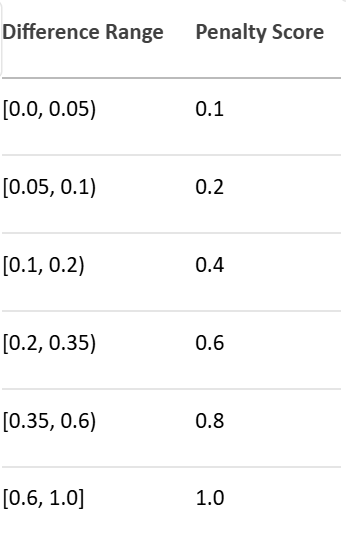
and  Scientific Basis for Penalty Intervals
The penalty intervals align with known stress thresholds in crop science:
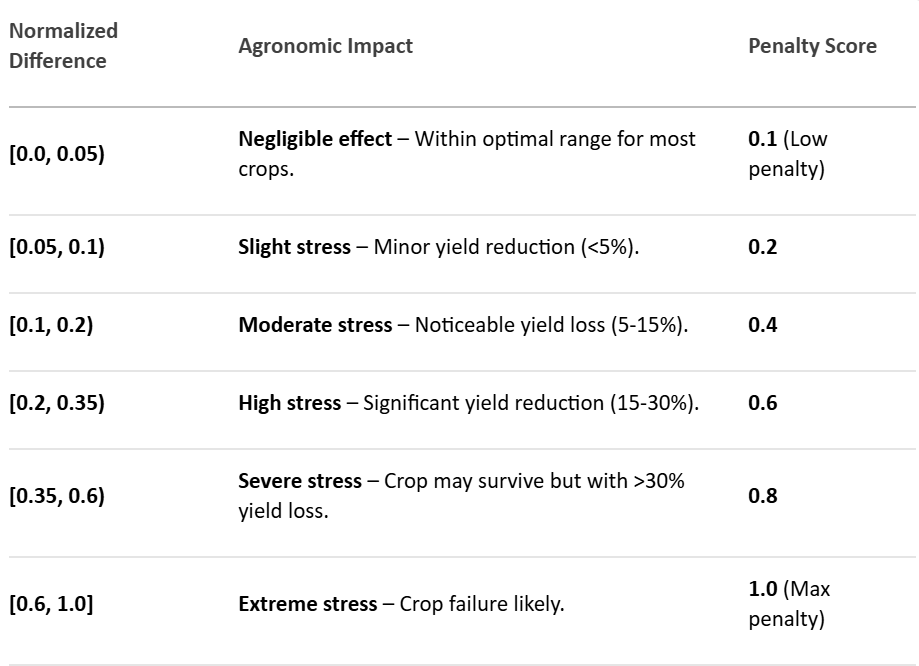

 Supporting Research:
Soil pH & Nutrient Availability
Studies show that pH deviations >0.5 units from optimal can reduce nutrient uptake by 20-50% (Brady & Weil, 2008).
Hence, a 0.1 normalized difference (~0.5 pH units) triggers a moderate penalty.
Temperature Stress
Each crop has an optimal temperature range.
Deviations >2°C reduce photosynthetic efficiency (Hatfield & Prueger, 2015).
Our 0.1-0.2 interval (~2-4°C difference) aligns with this threshold.
Water & Rainfall Mismatch
A 20% deviation from optimal rainfall can reduce yields by 10-25% (FAO, 2017).
Thus, penalties increase sharply beyond 0.2 normalized difference.

And each penaltie has a weight:
Feature: Nitrogen (N)
Weight: 0.18
Scientific Justification: Nitrogen is the most limiting nutrient for photosynthesis and yield. Deficiencies can reduce biomass by 30–50%.
Key References: Marschner (2012), FAO Soils Bulletin 14

Feature: Phosphorus (P)
Weight: 0.14
Scientific Justification: Phosphorus is vital for root development and energy transfer. Shortages can reduce yields by 20–40%.
Key References: Havlin et al. (2013), IPNI Phosphorus Guide

Feature: Potassium (K)
Weight: 0.13
Scientific Justification: Potassium regulates water uptake and stress resistance. Deficiencies increase susceptibility to drought.
Key References: Marschner (2012), FAO Irrigation Paper 56

Feature: Temperature
Weight: 0.16
Scientific Justification: Each 1°C deviation from the optimal temperature reduces growth rates by 5–10%. Extreme heat can cause sterility.
Key References: Taiz & Zeiger (2015)

Feature: Rainfall
Weight: 0.15
Scientific Justification: A 20% shortfall in rainfall can reduce yields by 15–25% in rainfed agricultural systems.
Key References: FAO Irrigation Paper 56

Feature: pH
Weight: 0.12
Scientific Justification: Soil pH affects nutrient solubility. Deviations greater than 0.5 units can lock up 30–50% of available nutrients.
Key References: NC State Extension (2014)

Feature: Humidity
Weight: 0.12
Scientific Justification: High humidity promotes fungal diseases, while low humidity increases water stress in crops.
Key References: Environmental and Experimental Botany (2004)

-We have also the gift_score:
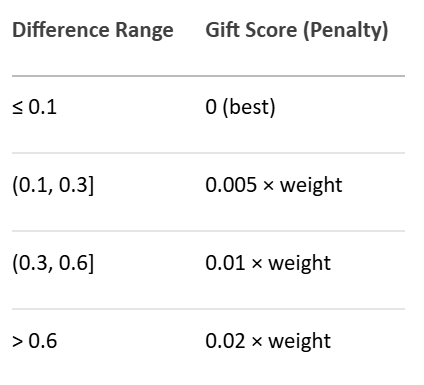



In [32]:
# Helper Functions
def compute_gift(gift_values, user_inputs, gift_ranges):
    gift_score = 0
    def get_interval_gift(diff, weight):
        return 0.02 * weight if diff > 0.6 else 0.01 * weight if diff > 0.3 else 0.005 * weight if diff > 0.1 else 0
    def compute_feature_gift(user_val, optimal_val, range_min, range_max, weight):
        if range_max == range_min: return 0
        diff = abs(user_val - optimal_val) / (range_max - range_min)
        return get_interval_gift(diff, weight)
    def compute_water_efficiency_gift(user_inputs, eff_min, eff_max, weight):
        rainfall = user_inputs.get('rainfall', 1)
        irrigation = user_inputs.get('irrigation_frequency', 1)
        source = user_inputs.get('water_source_type', 1)
        if irrigation == 0: irrigation = 1
        source_score = 1.0 if source == 1 else 1.5 if source == 2 else 2.0
        efficiency = rainfall / (irrigation * source_score)
        if eff_max == eff_min: return 0
        diff = abs(eff_max - efficiency) / (eff_max - eff_min)
        return get_interval_gift(diff, weight)
    for feature, weight in gift_weights.items():
        user_val = user_inputs.get(feature, 0)
        range_min, range_max = gift_ranges.get(feature, (0, 1))
        if feature == 'water_usage_efficiency':
            gift_score += compute_water_efficiency_gift(user_inputs, range_min, range_max, weight)
        else:
            gift_score += compute_feature_gift(user_val, range_min, range_min, range_max, weight)
    return gift_score

def compute_heuristic(gift_score, penalty):
    return penalty + gift_score

def normalize_values(values, feature_ranges, features_to_normalize):
    normalized = {}
    for k, v in values.items():
        if k not in features_to_normalize:
            continue
        min_val, max_val = feature_ranges[k]
        if max_val == min_val:
            normalized[k] = 0
        else:
            normalized[k] = (v - min_val) / (max_val - min_val)
    return normalized

def compute_penalty_by_depth(user_inputs, node_avg_values, feature_ranges, current_depth, feature_order, penalty_weights):
    penalty = 0
    active_features = feature_order[:current_depth] if current_depth > 0 else feature_order
    normalized_user = normalize_values(user_inputs, feature_ranges, active_features)
    normalized_node = normalize_values(node_avg_values, feature_ranges, active_features)
    for feature in active_features:
        user_val = normalized_user.get(feature, 0)
        node_val = normalized_node.get(feature, 0)
        weight = penalty_weights.get(feature, 1)
        diff = abs(user_val - node_val)
        penalty += (1.0 if diff >= 0.6 else 0.8 if diff >= 0.35 else 0.6 if diff >= 0.2 else 0.4 if diff >= 0.1 else 0.2 if diff >= 0.05 else 0.1) * weight
    return penalty

def filter_rows_by_path(df, path):
    filtered_df = df.copy()
    for feature, (min_val, max_val) in path:
        filtered_df = filtered_df[(filtered_df[feature] >= min_val) & (filtered_df[feature] <= max_val)]
    return filtered_df

# **how to get more than one crop in the greedy and the A* algorithm:**

 In the Greedy Search and A* search implementation, we explored two strategies:

***Modified Goal State:*** We altered the goal condition so that the search continues until the top k best crops (based on heuristic scores) are found and stored in a result array.

***Iterative Search with Exclusion:*** Alternatively, we performed the Greedy Search iteratively k times. After each run, we excluded the previously selected crop from the search space to identify the next best alternative. The second strategy was the one I implemented in our project.


=== Testing Greedy Search ===
  Greedy Crop 1: mungbean (Compatibility: 88.7%)
  Greedy Runtime: 23.3552s


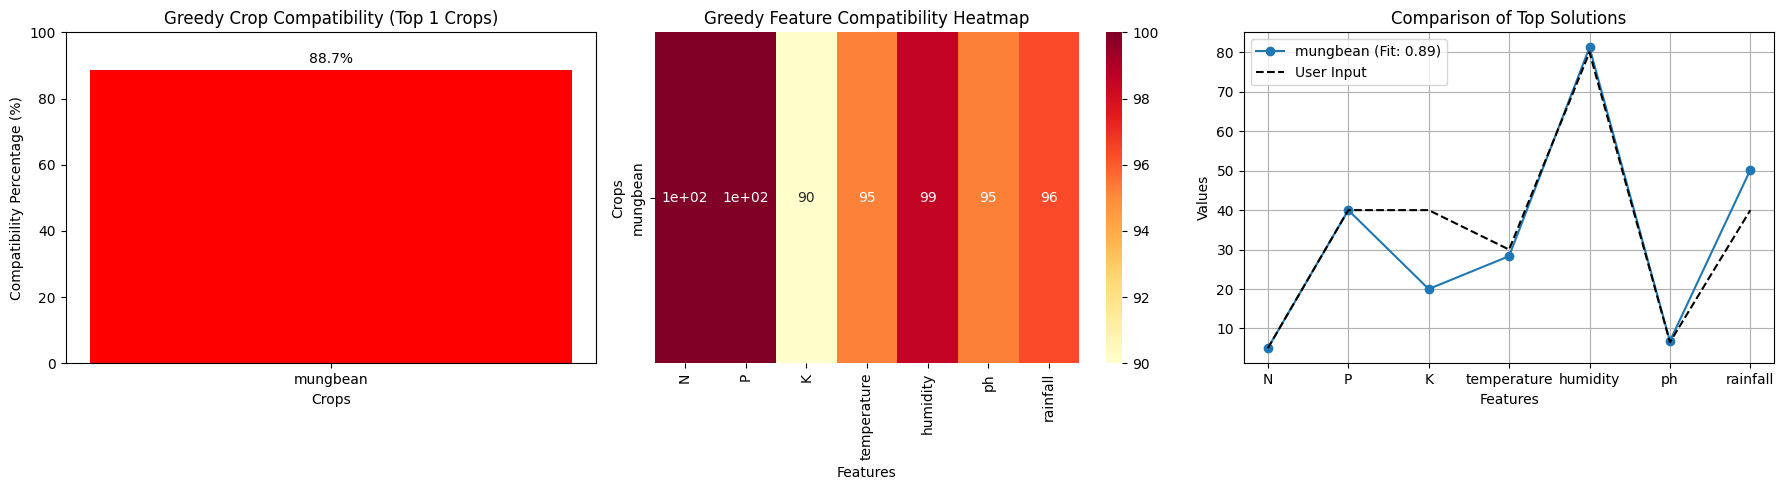

In [33]:
# Greedy Search
class CropNode:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0 if parent is None else parent.depth + 1
    def __hash__(self): return hash(tuple(self.state['path']))
    def __eq__(self, other): return isinstance(other, CropNode) and self.state['path'] == other.state['path']
    def __lt__(self, other): return self.state['heuristic_score'] < other.state['heuristic_score']

class CropPredictionProblemSearch:
    def __init__(self, initial_state, user_inputs, feature_order, df):
        self.initial_state = initial_state
        self.user_inputs = user_inputs
        self.feature_order = feature_order
        self.df = df
    def is_goal(self, state): return state['depth'] == len(self.feature_order)
    def get_valid_actions(self, state):
        if state['depth'] >= len(self.feature_order): return []
        feature = self.feature_order[state['depth']]
        return [(feature, interval) for interval in self.get_intervals(feature)]
    def get_intervals(self, feature):
        min_val, max_val = self.df[feature].min(), self.df[feature].max()
        step = interval_sizes[feature]
        if step <= 0: step = 1.0
        num_intervals = max(1, int((max_val - min_val) / step) + 1)
        intervals = []
        for i in range(num_intervals):
            start = min_val + i * step
            end = min(start + step, max_val)
            intervals.append((start, end))
            if end == max_val: break
        if intervals and intervals[-1][1] < max_val:
            intervals.append((intervals[-1][1], max_val))
        return intervals
    def apply_action(self, state, action):
        feature, interval = action
        new_path = state['path'] + [(feature, interval)]
        filtered = filter_rows_by_path(self.df, new_path)
        if len(filtered) == 0: return None
        avg_vals = filtered.mean(numeric_only=True).to_dict()
        crops = filtered['label'].tolist()
        crop_dist = dict(Counter(crops))
        dominant_crop = max(crop_dist, key=crop_dist.get, default=None) if crop_dist else None
        dominant_crop_ratio = crop_dist[dominant_crop] / len(crops) if crops and dominant_crop in crop_dist else 0
        gift_values = {k: avg_vals.get(k, 0) for k in gift_weights.keys()}
        gift_ranges = {k: (filtered[k].min(), filtered[k].max()) for k in gift_values.keys() if k in filtered.columns and k != 'water_usage_efficiency'}
        efficiencies = []
        for _, row in filtered.iterrows():
            if row['irrigation_frequency'] > 0:
                source_score = 1.0 if row['water_source_type'] == 1 else 1.5 if row['water_source_type'] == 2 else 2.0
                efficiency = row['rainfall'] / (row['irrigation_frequency'] * source_score)
                efficiencies.append(efficiency)
        gift_ranges['water_usage_efficiency'] = (min(efficiencies), max(efficiencies)) if efficiencies else (0.1, 1.0)
        gift_values['water_usage_efficiency'] = sum(efficiencies) / len(efficiencies) if efficiencies else 0.5
        penalty = compute_penalty_by_depth(self.user_inputs, avg_vals, feature_ranges, len(new_path), self.feature_order, penalty_weights)
        gift_score = compute_gift(gift_values, self.user_inputs, gift_ranges)
        heuristic = compute_heuristic(gift_score, penalty)
        return {
            'path': new_path,
            'path_values': {k: (a + b) / 2 for k, (a, b) in new_path},
            'valid_rows': filtered.index.tolist(),
            'crop_distribution': crop_dist,
            'dominant_crop': dominant_crop,
            'dominant_crop_ratio': dominant_crop_ratio,
            'average_values': avg_vals,
            'gift_values': gift_values,
            'heuristic_score': heuristic,
            'depth': len(new_path)
        }

def greedy_search_k_best(problem, k=1, max_iterations=10000):
    root_node = CropNode(problem.initial_state)
    frontier = [(root_node.state['heuristic_score'], root_node)]
    heapq.heapify(frontier)
    goal_nodes = []
    visited = set()
    seen_crops = set()
    iteration = 0
    while frontier and iteration < max_iterations and len(goal_nodes) < k:
        iteration += 1
        _, node = heapq.heappop(frontier)
        node_hash = hash(node)
        if node_hash in visited: continue
        visited.add(node_hash)
        if problem.is_goal(node.state):
            crop = node.state['dominant_crop']
            if crop and crop not in seen_crops:
                goal_nodes.append(node)
                seen_crops.add(crop)
            continue
        for action in problem.get_valid_actions(node.state):
            new_state = problem.apply_action(node.state, action)
            if new_state:
                new_node = CropNode(new_state, node, action)
                heapq.heappush(frontier, (new_state['heuristic_score'], new_node))
    return [{'crop': node.state['dominant_crop'], 'heuristic_score': node.state['heuristic_score'], 'path_values': node.state['path_values'], 'path': node.state['path']} for node in goal_nodes[:k]] if goal_nodes else [{'crop': None, 'heuristic_score': 0, 'path_values': {}, 'path': []}] * k

# Testing Genetic Algorithm with Visualization
user_input = {
    'N': 5, 'P': 40, 'K': 40, 'temperature': 30, 'humidity': 80, 'ph': 6.5, 'rainfall': 40,
    'fertilizer_usage': 120, 'co2_concentration': 400, 'irrigation_frequency': 1,
    'soil_type': 1, 'water_source_type': 1
}
k = 1  # Number of distinct crops to find
# Testing Greedy Search with Visualization
initial_state = {
    'path': [], 'path_values': {}, 'valid_rows': df.index.tolist(),
    'crop_distribution': dict(Counter(df['label'])), 'dominant_crop': df['label'].mode()[0] if not df.empty else None,
    'dominant_crop_ratio': 1.0, 'average_values': df.mean(numeric_only=True).to_dict(),
    'gift_values': {}, 'heuristic_score': 0, 'depth': 0
}
search_problem = CropPredictionProblemSearch(initial_state, user_input, feature_order, df)

print("=== Testing Greedy Search ===")
greedy_start = time.time()
greedy_solutions = greedy_search_k_best(search_problem, k)
greedy_time = time.time() - greedy_start

# Print results
for i, sol in enumerate(greedy_solutions, 1):
    score = max(0, 100 - sol['heuristic_score'] * 100) if sol['crop'] else 0
    print(f"  Greedy Crop {i}: {sol['crop'] if sol['crop'] else 'None'} (Compatibility: {score:.1f}%)")
print(f"  Greedy Runtime: {greedy_time:.4f}s")

# Visualization: Bar Chart, Heatmap, and Line Plot
if greedy_solutions and any(sol['crop'] for sol in greedy_solutions):
    crops = [sol['crop'] for sol in greedy_solutions if sol['crop'] is not None]
    compatibilities = [max(0, 100 - sol['heuristic_score'] * 100) for sol in greedy_solutions if sol['crop'] is not None]

    # Bar Chart
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.bar(crops, compatibilities, color='red')
    plt.title(f'Greedy Crop Compatibility (Top {k} Crops)')
    plt.xlabel('Crops')
    plt.ylabel('Compatibility Percentage (%)')
    plt.ylim(0, 100)
    for i, v in enumerate(compatibilities):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    # Heatmap for Feature Compatibility
    features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    compatibility_matrix = []
    for sol in greedy_solutions:
        if sol['crop']:
            crop_data = sol['path_values']
            row = []
            for feature in features:
                user_val = user_input.get(feature, 0)
                crop_val = crop_data.get(feature, 0)
                min_val, max_val = df[feature].min(), df[feature].max()
                if max_val == min_val:
                    compat = 0 if user_val != crop_val else 1
                else:
                    normalized_diff = abs((user_val - min_val) / (max_val - min_val) - (crop_val - min_val) / (max_val - min_val))
                    compat = max(0, 1 - normalized_diff)
                row.append(compat * 100)
            compatibility_matrix.append(row)

    plt.subplot(1, 3, 2)
    sns.heatmap(compatibility_matrix, annot=True, cmap='YlOrRd', yticklabels=crops, xticklabels=features)
    plt.title('Greedy Feature Compatibility Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Crops')

    # Line Plot for Comparison of Top Solutions
    plt.subplot(1, 3, 3)
    for i, sol in enumerate(greedy_solutions):
        if sol['crop']:
            values = [sol['path_values'].get(f, 0) for f in features]
            fit_score = max(0, 1 - sol['heuristic_score'])
            plt.plot(features, values, marker='o', label=f'{sol["crop"]} (Fit: {fit_score:.2f})')
    plt.plot(features, [user_input.get(f, 0) for f in features], 'k--', label='User Input')
    plt.title('Comparison of Top Solutions')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("  No valid Greedy solutions to plot for compatibility.")

=== Testing A* Search ===
  A* Crop 1: mungbean (Compatibility: 88.7%)
  A* Runtime: 19.5807s


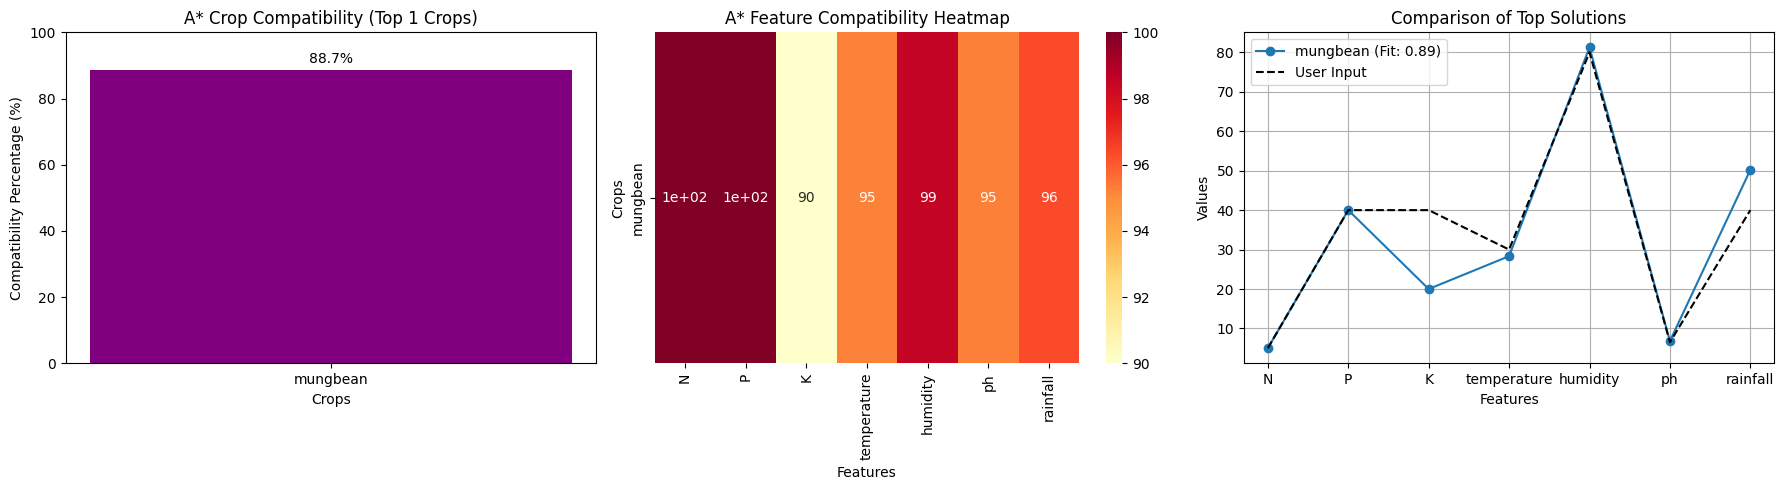

In [34]:
# A* Search
def a_star_search_k_best(problem, k=1, max_iterations=10000):
    root_node = CropNode(problem.initial_state)
    frontier = [(root_node.path_cost + root_node.state['heuristic_score'], root_node)]
    heapq.heapify(frontier)
    goal_nodes = []
    visited = set()
    seen_crops = set()
    iteration = 0
    while frontier and iteration < max_iterations and len(goal_nodes) < k:
        iteration += 1
        _, node = heapq.heappop(frontier)
        node_hash = hash(node)
        if node_hash in visited: continue
        visited.add(node_hash)
        if problem.is_goal(node.state):
            crop = node.state['dominant_crop']
            if crop and crop not in seen_crops:
                goal_nodes.append(node)
                seen_crops.add(crop)
            continue
        for action in problem.get_valid_actions(node.state):
            new_state = problem.apply_action(node.state, action)
            if new_state:
                new_path_cost = node.path_cost + compute_cost(problem.user_inputs, new_state['average_values'], feature_ranges, node.depth + 1, penalty_weights)
                new_node = CropNode(new_state, node, action, path_cost=new_path_cost)
                heapq.heappush(frontier, (new_node.path_cost + new_node.state['heuristic_score'], new_node))
    return [{'crop': node.state['dominant_crop'], 'heuristic_score': node.state['heuristic_score'], 'path_values': node.state['path_values'], 'path': node.state['path']} for node in goal_nodes[:k]] if goal_nodes else [{'crop': None, 'heuristic_score': 0, 'path_values': {}, 'path': []}] * k

def compute_cost(user_inputs, node_avg_values, feature_ranges, current_depth, penalty_weights):
    cost = 0
    active_features = feature_order[:current_depth] if current_depth > 0 else feature_order
    normalized_user = normalize_values(user_inputs, feature_ranges, active_features)
    normalized_node = normalize_values(node_avg_values, feature_ranges, active_features)
    for feature in active_features:
        user_val = normalized_user.get(feature, 0)
        node_val = normalized_node.get(feature, 0)
        penalty = penalty_weights.get(feature, 1)
        cost += penalty * abs(user_val - node_val)
    return cost

# Testing A* Search with Visualization
print("=== Testing A* Search ===")
astar_start = time.time()
astar_solutions = a_star_search_k_best(search_problem, k)
astar_time = time.time() - astar_start

# Print results
for i, sol in enumerate(astar_solutions, 1):
    score = max(0, 100 - sol['heuristic_score'] * 100) if sol['crop'] else 0
    print(f"  A* Crop {i}: {sol['crop'] if sol['crop'] else 'None'} (Compatibility: {score:.1f}%)")
print(f"  A* Runtime: {astar_time:.4f}s")

# Visualization: Bar Chart, Heatmap, and Line Plot
if astar_solutions and any(sol['crop'] for sol in astar_solutions):
    crops = [sol['crop'] for sol in astar_solutions if sol['crop'] is not None]
    compatibilities = [max(0, 100 - sol['heuristic_score'] * 100) for sol in astar_solutions if sol['crop'] is not None]

    # Bar Chart
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.bar(crops, compatibilities, color='purple')
    plt.title(f'A* Crop Compatibility (Top {k} Crops)')
    plt.xlabel('Crops')
    plt.ylabel('Compatibility Percentage (%)')
    plt.ylim(0, 100)
    for i, v in enumerate(compatibilities):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    # Heatmap for Feature Compatibility
    features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    compatibility_matrix = []
    for sol in astar_solutions:
        if sol['crop']:
            crop_data = sol['path_values']
            row = []
            for feature in features:
                user_val = user_input.get(feature, 0)
                crop_val = crop_data.get(feature, 0)
                min_val, max_val = df[feature].min(), df[feature].max()
                if max_val == min_val:
                    compat = 0 if user_val != crop_val else 1
                else:
                    normalized_diff = abs((user_val - min_val) / (max_val - min_val) - (crop_val - min_val) / (max_val - min_val))
                    compat = max(0, 1 - normalized_diff)
                row.append(compat * 100)
            compatibility_matrix.append(row)

    plt.subplot(1, 3, 2)
    sns.heatmap(compatibility_matrix, annot=True, cmap='YlOrRd', yticklabels=crops, xticklabels=features)
    plt.title('A* Feature Compatibility Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Crops')

    # Line Plot for Comparison of Top Solutions
    plt.subplot(1, 3, 3)
    for i, sol in enumerate(astar_solutions):
        if sol['crop']:
            values = [sol['path_values'].get(f, 0) for f in features]
            fit_score = max(0, 1 - sol['heuristic_score'])
            plt.plot(features, values, marker='o', label=f'{sol["crop"]} (Fit: {fit_score:.2f})')
    plt.plot(features, [user_input.get(f, 0) for f in features], 'k--', label='User Input')
    plt.title('Comparison of Top Solutions')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("  No valid A* solutions to plot for compatibility.")

# **The genetic search algorithm:**
*Individual class:*
Represent a candidate solution (chromosome)
crop_type: Used to hold the name of the crop (e.g., "wheat", "corn") for determining the plant species being tested.

*growth_stage:* Used to hold the current growth stage (e.g., "seedling", "mature") since crops have varying performances at varying stages.

env_conditions (Dictionary): Used to hold environmental conditions (temperature, soil moisture, etc.) which need to be aligned with user local conditions for optimal growth.

*crop_info:* Used to hold crop-specific characteristics (frost risk, irrigation need, etc.) to test costs, risks, and efficiency as well as environmental fit.

*CropPredictionProblem class:*
Represent our problem we Initializes it with the data from a CSV file, a set of the user's environmental conditions, crop dictionary that contain the data of crops and the self._precompute_column_ranges() that Prepares the min/max of each numeric feature so we can normalize them later.
Methods:
• _create_crop_dictionary: used to initialise the crop_dictionary
• generate_random_individual: it generate random idividual to initialise population latter in the  geneticAlgorithm class
• normalize_value: Normalizes a numeric value (in the range [0,1] ) using min-max normalization, used in the calculation of the fitness since the values of the gens are from deferent units.
• fitness: take an individual and calculate its fitness using the formula: fitness=0.4 × match_score + 0.2 × (1 − resource_usage)+ 0.2 × (1−risk_score) + 0.2 × efficiency_score  
which Measures how well a crop matches user conditions while minimizing resource use and risks using this methods:
*• _match_score:*  Measures how closely the crop's environmental needs to match user conditions. It takes env_conditions of the individual and user_env
match_score=1−(total conditions∑∣normalized(envi)−normalized(useri)∣)
*• _resource_usage_score:* Measures how demanding the crop is in terms of irrigation and fertilizer, theLower is better (we subtract it in fitness)..
it takes: crop_info of the individual
Formula:
resource_usage=(normalized(irrigation_frequency)+normalized(fertilizer_usage) )/2

*• _risk_score:* Evaluates risk due to frost and pests Lower is better (we subtract it in fitness)..
it takes crop_info
Formula: risk_score=(normalized(frost_risk)+normalized(pest_pressure) )/2

*• _efficiency_score:* Evaluates how space- and water-efficient a crop is, the Higher is better — reflects good use of land and water.
it takes crop_info
Formula: efficiency_score = ( normalized (crop_density)+ (1−normalized(water_usage_efficiency)) ) / 2
*• find_closest_crop:* since the the mutation and the crossover can provide an individual that is not in the data set, we find the crop that match this new parameters and assing it in the new generated individual.
GeneticAlgorithm class:
init
Method: Initializes the genetic algorithm with configuration settings.
Input:

• problem: the problem instance (e.g., CropPredictionProblem)

• population_size: number of individuals per generation

• generations: number of iterations to evolve

• mutation_rate: probability of mutation

*• tournament_size:* number of individuals selected for tournament

Output: None (stores parameters)

*• initialize_population*
Method: Creates the initial population using random individuals from the problem.

Input: None

Output: List of Individual objects
Used: At the beginning of the solve method.

*• evolve_population:*
Evolves the population by applying elitism, tournament selection, crossover, and mutation.

Input:
*• population:* current generation of individuals
Output: New population list
Note: Keeps best individual (elitism) and replaces the rest via selection, crossover, and mutation.

*• _tournament_selection:*
Selects the best individual among a random subset (tournament) of the population.

Input:
*• population:* list of individuals

Output: Best individual in the tournament
Selection Method: Tournament Selection was chosen because it maintains diversity and is simple yet effective in promoting better individuals.

*• _crossover:*
Produces a child by combining environmental conditions from two parents.

Input:
*• parent1, parent2:* selected individuals

Output: New Individual object

*Crossover Method:* Blend crossover only on env_conditions — numerical values are averaged, categorical values are randomly picked — chosen for simplicity and realism in environmental blending.

*• _mutate:*
Applies a small random change to the environmental conditions of an individual.

Input:
*• individual:* an Individual object
Output: Mutated individual (new Individual)
Mutation Method: Uniform mutation only on env_conditions — ±10% variation for numerical attributes — chosen for controlled randomness within valid bounds.

*• solve:*
 Runs the full genetic algorithm process and returns the best-found individual.

Input: None

Output: Best Individual after all generations
# **How to get more than one crop:**
In the Genetic Algorithm, we added a function *get_k_distinct_crops* that uses the genetic search and runs it k times. And in each time we run it, it chooses the best suitable crop removes it from the dataset, and runs the next search.

=== Testing Genetic Algorithm ===
  GA Crop 1: mungbean (Compatibility: 38.3%)
  GA Runtime: 50.5962s


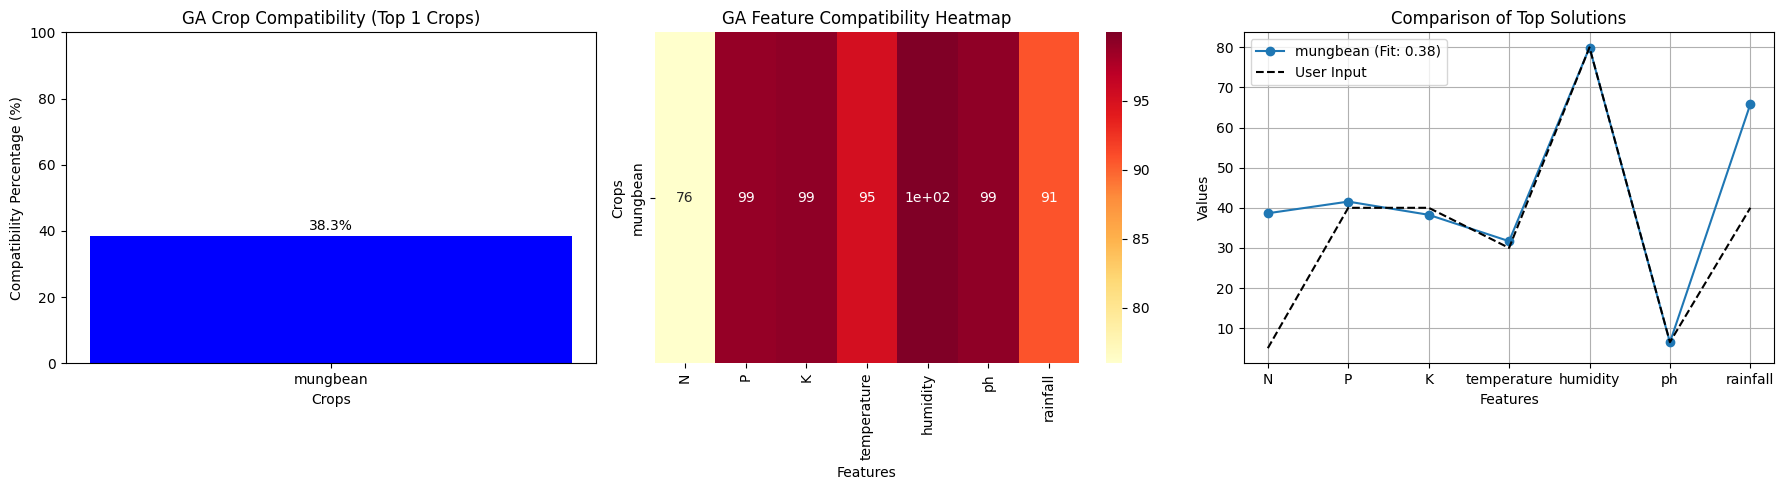

In [35]:
# GA Classes
class Individual:
    def __init__(self, crop_type, growth_stage, env_conditions, crop_info):
        self.crop_type = crop_type
        self.growth_stage = growth_stage
        self.env_conditions = env_conditions
        self.crop_info = crop_info
    def __str__(self):
        return f"Crop Type: {self.crop_type}\nGrowth Stage: {self.growth_stage}"

class CropPredictionProblemGA:
    def __init__(self, data_file, user_input, excluded_crops=None):
        self.crop_data = pd.read_csv(data_file)
        self.user_env = user_input
        self.excluded_crops = excluded_crops if excluded_crops else []
        self.crops_dictionary = self._create_crop_dictionary()
        self._precompute_column_ranges()
    def _precompute_column_ranges(self):
        self.column_ranges = {}
        for col in self.crop_data.columns:
            if col not in ['label', 'growth_stage', 'soil_type', 'water_source_type']:
                min_val = self.crop_data[col].min()
                max_val = self.crop_data[col].max()
                self.column_ranges[col] = {'min': min_val, 'max': max_val if max_val > min_val else min_val + 1}
    def _create_crop_dictionary(self):
        crop_dict = {}
        for _, row in self.crop_data.iterrows():
            crop_type = row['label']
            if crop_type not in self.excluded_crops:
                entry = {
                    "growth_stage": row['growth_stage'],
                    "env_conditions": {k: row[k] for k in ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'soil_type', 'water_source_type', 'co2_concentration']},
                    "crop_info": {k: row[k] for k in ['irrigation_frequency', 'fertilizer_usage', 'pest_pressure']}
                }
                crop_dict.setdefault(crop_type, []).append(entry)
        return crop_dict
    def generate_random_individual(self):
        if not self.crops_dictionary:
            return Individual("unknown", "unknown", {}, {})
        crop_type = random.choice(list(self.crops_dictionary.keys()))
        growth_data = random.choice(self.crops_dictionary[crop_type])
        return Individual(crop_type, growth_data['growth_stage'], growth_data['env_conditions'], growth_data['crop_info'])
    def normalize_value(self, column, value):
        if column not in self.column_ranges: return 0
        col_range = self.column_ranges[column]
        denominator = col_range['max'] - col_range['min']
        return (value - col_range['min']) / denominator if denominator != 0 else 0
    def fitness(self, crop):
        if not crop.env_conditions or not self.user_env: return 0
        return 0.4 * self._match_score(crop.env_conditions, self.user_env)
    def _match_score(self, env_conditions, user_env):
        score = 0
        counter = 0
        for condition in env_conditions:
            if condition in ['soil_type', 'water_source_type']:
                if env_conditions[condition] != user_env.get(condition, env_conditions[condition]):
                    score += 1
            else:
                score += abs(self.normalize_value(condition, env_conditions[condition]) - self.normalize_value(condition, user_env.get(condition, 0)))
            counter += 1
        return 1 - (score / counter) if counter > 0 else 0
    def find_closest_crop(self, target_env):
        if not self.crops_dictionary:
            return Individual("unknown", "unknown", target_env, {})
        best_score, best_crop = -float('inf'), None
        for crop_type in self.crops_dictionary:
            for crop_data in self.crops_dictionary[crop_type]:
                score = self._match_score(crop_data['env_conditions'], target_env)
                if score > best_score:
                    best_score = score
                    best_crop = (crop_type, crop_data)
        return Individual(best_crop[0], best_crop[1]['growth_stage'], target_env, best_crop[1]['crop_info']) if best_crop else Individual("unknown", "unknown", target_env, {})

class GeneticAlgorithm:
    def __init__(self, problem, population_size=100, generations=80, mutation_rate=0.2, tournament_size=3):
        self.problem = problem
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
    def solve(self):
        population = [self.problem.generate_random_individual() for _ in range(self.population_size)]
        if not population or all(ind.crop_type == "unknown" for ind in population):
            return Individual("unknown", "unknown", {}, {})
        best_solution = max(population, key=lambda x: self.problem.fitness(x))
        for _ in range(self.generations):
            population = self.evolve_population(population)
            current_best = max(population, key=lambda x: self.problem.fitness(x))
            if self.problem.fitness(current_best) > self.problem.fitness(best_solution):
                best_solution = copy.deepcopy(current_best)
        return best_solution
    def evolve_population(self, population):
        new_pop = [max(population, key=lambda x: self.problem.fitness(x))]
        while len(new_pop) < self.population_size:
            p1, p2 = [self._tournament_selection(population) for _ in range(2)]
            child = self._crossover(p1, p2)
            if random.random() < self.mutation_rate:
                child = self._mutate(child)
            new_pop.append(child)
        return new_pop
    def _tournament_selection(self, population):
        tournament = random.sample(population, min(self.tournament_size, len(population)))
        return max(tournament, key=lambda x: self.problem.fitness(x))
    def _crossover(self, p1, p2):
        if not p1.env_conditions or not p2.env_conditions:
            return self.problem.generate_random_individual()
        child_env = {}
        for key in p1.env_conditions:
            if key in ['soil_type', 'water_source_type']:
                child_env[key] = random.choice([p1.env_conditions[key], p2.env_conditions[key]])
            else:
                child_env[key] = (p1.env_conditions[key] + p2.env_conditions[key]) / 2
        return self.problem.find_closest_crop(child_env)
    def _mutate(self, individual):
        if not individual.env_conditions:
            return self.problem.generate_random_individual()
        mutated_env = copy.deepcopy(individual.env_conditions)
        for key in mutated_env:
            if key not in ['soil_type', 'water_source_type']:
                col_range = self.problem.column_ranges.get(key, {'min': 0, 'max': 1})
                current_val = mutated_env[key]
                mutation_range = (col_range['max'] - col_range['min']) * 0.1
                mutated_val = current_val + random.uniform(-mutation_range, mutation_range)
                mutated_env[key] = max(col_range['min'], min(col_range['max'], mutated_val))
        return self.problem.find_closest_crop(mutated_env)

def get_k_distinct_crops(data_file, user_input, population_size=50, generations=120, mutation_rate=0.2, tournament_size=3, k=1):
    top_k_solutions = []
    excluded_crops = []
    for i in range(k):
        problem = CropPredictionProblemGA(data_file, user_input, excluded_crops)
        if not problem.crops_dictionary:
            break
        ga = GeneticAlgorithm(problem, population_size, generations, mutation_rate, tournament_size)
        best_solution = ga.solve()
        if best_solution.crop_type == "unknown":
            break
        top_k_solutions.append(best_solution)
        excluded_crops.append(best_solution.crop_type)
    return top_k_solutions

# Testing Genetic Algorithm with Visualization
ga_problem = CropPredictionProblemGA('Crop_recommendationV2.csv', user_input)

print("=== Testing Genetic Algorithm ===")
ga_start = time.time()
ga_solutions = get_k_distinct_crops('Crop_recommendationV2.csv', user_input, k=k)
ga_time = time.time() - ga_start

# Print results
for i, sol in enumerate(ga_solutions, 1):
    score = ga_problem.fitness(sol) * 100 if sol.crop_type != "unknown" else 0
    print(f"  GA Crop {i}: {sol.crop_type if sol.crop_type != 'unknown' else 'None'} (Compatibility: {score:.1f}%)")
print(f"  GA Runtime: {ga_time:.4f}s")

# Visualization: Bar Chart, Heatmap, and Line Plot
if ga_solutions and not all(sol.crop_type == "unknown" for sol in ga_solutions):
    crops = [sol.crop_type for sol in ga_solutions if sol.crop_type != "unknown"]
    compatibilities = [ga_problem.fitness(sol) * 100 for sol in ga_solutions if sol.crop_type != "unknown"]

    # Bar Chart
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.bar(crops, compatibilities, color='blue')
    plt.title(f'GA Crop Compatibility (Top {k} Crops)')
    plt.xlabel('Crops')
    plt.ylabel('Compatibility Percentage (%)')
    plt.ylim(0, 100)
    for i, v in enumerate(compatibilities):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    # Heatmap for Feature Compatibility
    features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    compatibility_matrix = []
    for sol in ga_solutions:
        if sol.crop_type != "unknown":
            crop_data = sol.env_conditions
            row = []
            for feature in features:
                user_val = user_input.get(feature, 0)
                crop_val = crop_data.get(feature, 0)
                min_val, max_val = df[feature].min(), df[feature].max()
                if max_val == min_val:
                    compat = 0 if user_val != crop_val else 1
                else:
                    normalized_diff = abs((user_val - min_val) / (max_val - min_val) - (crop_val - min_val) / (max_val - min_val))
                    compat = max(0, 1 - normalized_diff)
                row.append(compat * 100)
            compatibility_matrix.append(row)

    plt.subplot(1, 3, 2)
    sns.heatmap(compatibility_matrix, annot=True, cmap='YlOrRd', yticklabels=crops, xticklabels=features)
    plt.title('GA Feature Compatibility Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Crops')

    # Line Plot for Comparison of Top Solutions
    plt.subplot(1, 3, 3)
    for i, sol in enumerate(ga_solutions):
        if sol.crop_type != "unknown":
            values = [sol.env_conditions.get(f, 0) for f in features]
            fit_score = ga_problem.fitness(sol)
            plt.plot(features, values, marker='o', label=f'{sol.crop_type} (Fit: {fit_score:.2f})')
    plt.plot(features, [user_input.get(f, 0) for f in features], 'k--', label='User Input')
    plt.title('Comparison of Top Solutions')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("  No valid GA solutions to plot for compatibility.")

# **Constraint Satisfaction Problem:**
To solve our constraint satisfaction problem we used a python library called *python-constraint*. The modules we used from the library are the following:


*   This imports the Problem class from the constraint module. It’s used to define the CSP you want to solve.
*  This method solves the problem by checking all possible values of "crop" (from the domain), and returns all values that satisfy the constraint function (feature_constraint).

If no crop satisfies the constraints, the result is an empty list.

1.   The Problem class which is used to define the problem we want to solve.
2.  "problem.addVariable("crop", crop_list)" adds a new variable crop and its domain crop_list to the problem we created.
3. "problem.addConstraint(feature_constraint, ["crop"])" this adds a new constraint function called feature_constraint applied to our crop variable. What it does is take the crop, look up its min and max values for all features and then checksif the user input falls within those ranges,if so it returns true.
4."problem.getSolutions()" This function returns the list of sulutions by checking for all possible values of crop.






In [36]:
from constraint import Problem # problem class from the library python-constraint
import pandas as pd
df = pd.read_csv("Crop_recommendationV2.csv")


problem = Problem()

user_inputs = {}


specific_features = [
    'N', 'P', 'K', 'temperature', 'humidity', 'rainfall', 'ph'
]

print("Please enter values for the following features:")

for feature in specific_features:
    while True:
        try:
            value = float(input(f"{feature}: "))
            user_inputs[feature] = value
            break
        except ValueError:
            print("Please enter a valid number.")



# this generates the specific feature dictionary, with the min and max values for every specific feature for every crop individually
specific_features = {}
for crop in df['label'].unique():
    crop_data = df[df['label'].str.lower() == crop.lower()]
    specific_features[crop] = {
        feature: {
            'min': crop_data[feature].min(),
            'max': crop_data[feature].max()
        }
        for feature in ['N', 'P', 'K', 'temperature', 'humidity', 'rainfall', 'ph']
    }


crop_list = list(specific_features.keys())
problem.addVariable("crop", crop_list)

def feature_constraint(crop_value): #this is the constraint checker function that checks if the user input fits in the constraints for every crop

    for feature, value in user_inputs.items():
        if feature in specific_features[crop_value]:
            range_ = specific_features[crop_value][feature]
            if not (range_['min'] <= value <= range_['max']):
                return False

    return True


problem.addConstraint(feature_constraint, ["crop"]) #adding the constraint check function to the crop variable
solutions = problem.getSolutions()

print("------------------------------------------------")
if not solutions:

  print("No suitable crop found for your land.")
  print("------------------------------------------------")
for sol in solutions:

    print("Possible crop:", sol["crop"])


Please enter values for the following features:
N: 2
P: 4
K: 50
temperature: 120
humidity: 40
rainfall: 120
ph: 102
------------------------------------------------
No suitable crop found for your land.
------------------------------------------------


# ***how to get more than one crop for the CSP search:**
In the CSP search , we have added a to it a *tolerance* , which allows us in the search to accept the assignment of a crop parameter interval if the user input does not exceed 0.1 of the crop's validation interval.

=== Testing CSP Search ===
  CSP Crop 1: mothbeans (Compatibility: 72.5%)
  CSP Runtime: 0.1083s


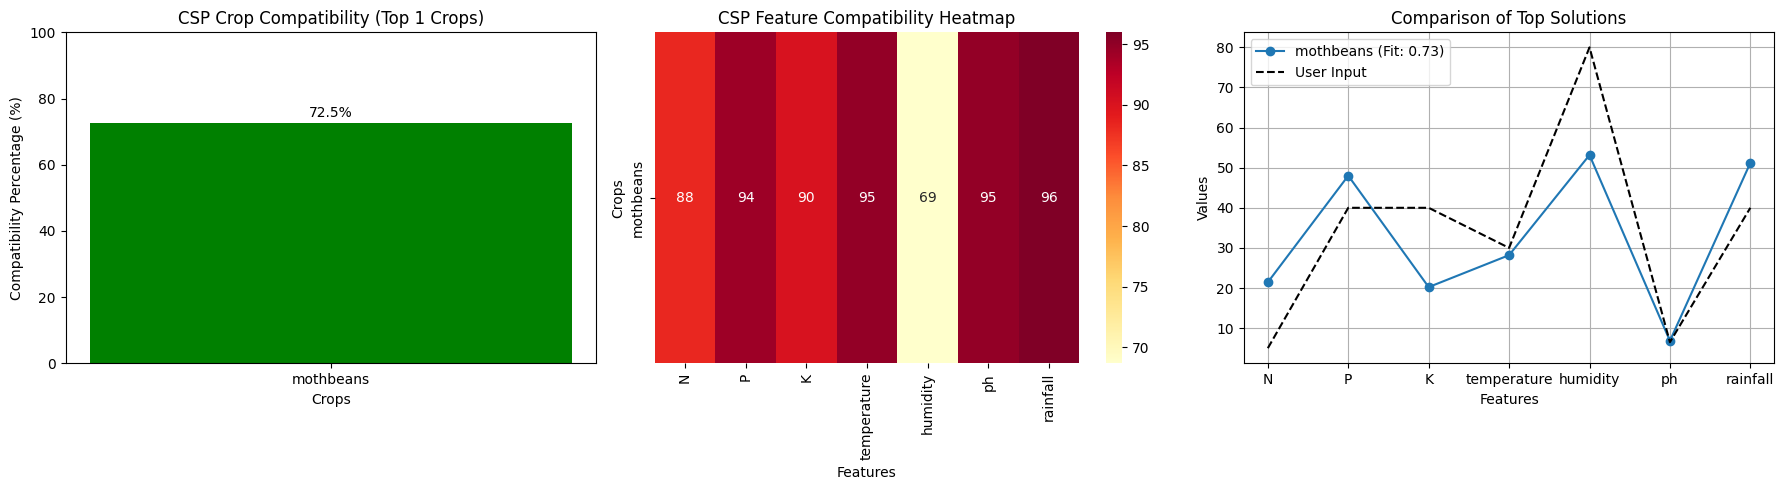

In [38]:
# CSP Implementation for more than one crop
def csp_search_k_crops(df, user_inputs, k=1, tolerance=0.1):
    specific_features = ['N', 'P', 'K', 'temperature', 'humidity', 'rainfall', 'ph']
    problem = Problem()
    specific_ranges = {}

    for crop in df['label'].unique():
        crop_data = df[df['label'].str.lower() == crop.lower()]
        specific_ranges[crop] = {
            feature: {
                'min': crop_data[feature].min(),
                'max': crop_data[feature].max()
            } for feature in specific_features if feature in crop_data
        }
        for feature, range_ in specific_ranges[crop].items():
            min_val, max_val = range_['min'], range_['max']
            range_width = max_val - min_val
            tol_min = min_val - range_width * tolerance
            tol_max = max_val + range_width * tolerance
            specific_ranges[crop][feature]['tol_min'] = tol_min
            specific_ranges[crop][feature]['tol_max'] = tol_max

    crop_list = list(specific_ranges.keys())
    problem.addVariable("crop", crop_list)

    def feature_constraint(crop_value):
        for feature, value in user_inputs.items():
            if feature in specific_features and feature in specific_ranges[crop_value]:
                range_ = specific_ranges[crop_value][feature]
                tol_min = range_['tol_min']
                tol_max = range_['tol_max']
                if not (tol_min <= value <= tol_max):
                    return False
        return True

    problem.addConstraint(feature_constraint, ["crop"])
    solutions = problem.getSolutions()

    if not solutions:
        compatibility_scores = []
        for crop in crop_list:
            score = 0
            count = 0
            for feature, value in user_inputs.items():
                if feature in specific_features and feature in specific_ranges[crop]:
                    min_val = specific_ranges[crop][feature]['min']
                    max_val = specific_ranges[crop][feature]['max']
                    range_width = max_val - min_val if max_val != min_val else 1
                    diff = abs(value - (min_val + max_val) / 2) / range_width
                    compatibility = max(0, 1 - diff)
                    score += compatibility
                    count += 1
            avg_score = score / count if count > 0 else 0
            compatibility_scores.append((crop, avg_score))

        compatibility_scores.sort(key=lambda x: x[1], reverse=True)
        solutions = [{'crop': crop} for crop, _ in compatibility_scores[:k]]

    results = []
    for sol in solutions:
        crop = sol['crop']
        crop_data = df[df['label'] == crop]
        avg_vals = crop_data.mean(numeric_only=True).to_dict()
        gift_values = {k: avg_vals.get(k, 0) for k in gift_weights.keys()}
        gift_ranges = {k: (crop_data[k].min(), crop_data[k].max()) for k in gift_values.keys() if k in crop_data.columns and k != 'water_usage_efficiency'}
        efficiencies = []
        for _, row in crop_data.iterrows():
            irrigation = row['irrigation_frequency'] if row['irrigation_frequency'] > 0 else 1
            source_score = 1.0 if row['water_source_type'] == 1 else 1.5 if row['water_source_type'] == 2 else 2.0
            efficiency = row['rainfall'] / (irrigation * source_score)
            efficiencies.append(efficiency)
        gift_ranges['water_usage_efficiency'] = (min(efficiencies), max(efficiencies)) if efficiencies else (0.1, 1.0)
        gift_values['water_usage_efficiency'] = sum(efficiencies) / len(efficiencies) if efficiencies else 0.5
        penalty = compute_penalty_by_depth(user_inputs, avg_vals, feature_ranges, len(feature_order), feature_order, penalty_weights)
        gift_score = compute_gift(gift_values, user_inputs, gift_ranges)
        heuristic = compute_heuristic(gift_score, penalty)
        path = [(f, (specific_ranges[crop][f]['tol_min'], specific_ranges[crop][f]['tol_max'])) for f in specific_features]
        results.append({
            'crop': crop,
            'heuristic_score': heuristic,
            'path_values': {f: avg_vals.get(f, 0) for f in specific_features},
            'path': path
        })
    results.sort(key=lambda x: x['heuristic_score'])
    return results[:k] if results else [{'crop': None, 'heuristic_score': 0, 'path_values': {}, 'path': []}] * k
# Testing CSP Search with Visualization
print("=== Testing CSP Search ===")
csp_start = time.time()
csp_solutions = csp_search_k_crops(df, user_input, k)
csp_time = time.time() - csp_start

# Print results
for i, sol in enumerate(csp_solutions, 1):
    score = max(0, 100 - sol['heuristic_score'] * 100) if sol['crop'] else 0
    print(f"  CSP Crop {i}: {sol['crop'] if sol['crop'] else 'None'} (Compatibility: {score:.1f}%)")
print(f"  CSP Runtime: {csp_time:.4f}s")

# Visualization: Bar Chart, Heatmap, and Line Plot
if csp_solutions and any(sol['crop'] for sol in csp_solutions):
    crops = [sol['crop'] for sol in csp_solutions if sol['crop'] is not None]
    compatibilities = [max(0, 100 - sol['heuristic_score'] * 100) for sol in csp_solutions if sol['crop'] is not None]

    # Bar Chart
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.bar(crops, compatibilities, color='green')
    plt.title(f'CSP Crop Compatibility (Top {k} Crops)')
    plt.xlabel('Crops')
    plt.ylabel('Compatibility Percentage (%)')
    plt.ylim(0, 100)
    for i, v in enumerate(compatibilities):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    # Heatmap for Feature Compatibility
    features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    compatibility_matrix = []
    for sol in csp_solutions:
        if sol['crop']:
            crop_data = sol['path_values']
            row = []
            for feature in features:
                user_val = user_input.get(feature, 0)
                crop_val = crop_data.get(feature, 0)
                min_val, max_val = df[feature].min(), df[feature].max()
                if max_val == min_val:
                    compat = 0 if user_val != crop_val else 1
                else:
                    normalized_diff = abs((user_val - min_val) / (max_val - min_val) - (crop_val - min_val) / (max_val - min_val))
                    compat = max(0, 1 - normalized_diff)
                row.append(compat * 100)
            compatibility_matrix.append(row)

    plt.subplot(1, 3, 2)
    sns.heatmap(compatibility_matrix, annot=True, cmap='YlOrRd', yticklabels=crops, xticklabels=features)
    plt.title('CSP Feature Compatibility Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Crops')

    # Line Plot for Comparison of Top Solutions
    plt.subplot(1, 3, 3)
    for i, sol in enumerate(csp_solutions):
        if sol['crop']:
            values = [sol['path_values'].get(f, 0) for f in features]
            fit_score = max(0, 1 - sol['heuristic_score'])
            plt.plot(features, values, marker='o', label=f'{sol["crop"]} (Fit: {fit_score:.2f})')
    plt.plot(features, [user_input.get(f, 0) for f in features], 'k--', label='User Input')
    plt.title('Comparison of Top Solutions')
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("  No valid CSP solutions to plot for compatibility.")